In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


Using TensorFlow backend.


In [2]:
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'
 
nTrain = 600
nVal = 150

In [31]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

from PIL import Image
print(Image.__file__)

import Image
print(Image.__file__)

/anaconda3/envs/mafat_keras/lib/python3.6/site-packages/PIL/Image.py
/anaconda3/envs/mafat_keras/lib/python3.6/site-packages/PIL/Image.py


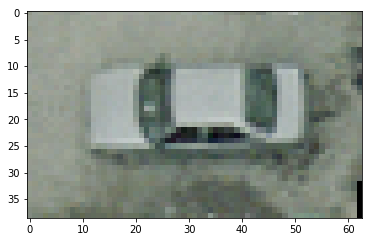

In [42]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=5,
    height_shift_range=5,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.0001, 1.1],
    channel_shift_range=0.9)

im = load_img('output/vehicles/10169.bmp')
plt.imshow(im)
plt.show()

x = img_to_array(im)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview2', save_prefix='augment', save_format='jpeg'):
    i += 1
    if i > 100:
        break  # otherwise the generator would loop indefinitely


In [ ]:
# from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
    
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
 
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))
 
train_generator = datagen.flow_from_directory(
    "output/vehicles",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)


In [23]:
from keras.applications import VGG16

image_size=224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0xb301baa90> False
<keras.layers.convolutional.Conv2D object at 0xb30f65c50> False
<keras.layers.convolutional.Conv2D object at 0xb310a5a20> False
<keras.layers.pooling.MaxPooling2D object at 0xb30ff5748> False
<keras.layers.convolutional.Conv2D object at 0xb30defdd8> False
<keras.layers.convolutional.Conv2D object at 0xb30860710> False
<keras.layers.pooling.MaxPooling2D object at 0xb30c42080> False
<keras.layers.convolutional.Conv2D object at 0xb30c42c18> False
<keras.layers.convolutional.Conv2D object at 0xb30a1f1d0> False
<keras.layers.convolutional.Conv2D object at 0xb30a19048> False
<keras.layers.pooling.MaxPooling2D object at 0xb30f3c160> False
<keras.layers.convolutional.Conv2D object at 0xb30f3ce80> False
<keras.layers.convolutional.Conv2D object at 0xb309f00f0> False
<keras.layers.convolutional.Conv2D object at 0xb30d9f438> False
<keras.layers.pooling.MaxPooling2D object at 0xb30dd9400> False
<keras.layers.convolutional.Conv2D obj

In [25]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2050      
Total params: 40,407,874
Trainable params: 32,772,610
Non-trainable params: 7,635,264
_________________________________________________________________


In [38]:
train_dir = './output/train'
validation_dir = './output/validation'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=4,
    width_shift_range=5,
    height_shift_range=5,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
validation_batchsize = 10
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=validation_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 9293 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.


In [39]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('small_last4.h5')

Epoch 1/30
 3/92 [..............................] - ETA: 27:33:22 - loss: 0.8200 - acc: 0.7267

KeyboardInterrupt: 

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

KeyError: 'acc'